<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/blob/main/Lab%202%20%E2%80%93%20Image%20Classification%2C%20Transfer%20Learning%2C%20and%20Face%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Header Lab 2](https://su2.utia.cas.cz/files/labs/23-202/header_lab2.png)

This lab provides an extensive exploration of image classification leveraging the power of Convolutional Neural Networks (CNNs) and the Rock Paper Scissors dataset. The key topics covered include data preparation, normalization, and model evaluation. Building on the previous knowledge of PyTorch, we will use PyTorch Lightning, a lightweight PyTorch wrapper, to simplify and optimize our deep learning models. We will also explore the concept of transfer learning with benchmark models like Alexnet, VGG, and ResNet, as well as delve into face detection technique. A significant focus will be on understanding and preventing overfitting in deep learning models.

**Course website:** [su2.utia.cas.cz/labs.html](https://su2.utia.cas.cz/labs.html)

## Schedule
Lab 0 – Introduction to Python and Basic Machine Learning

Lab 1 – Fundamentals of Deep Learning with PyTorch

*Lab 2 – Image Classification and Transfer Learning*

Lab 3 – Image Processing with Deep Learning

Lab 4 – Sequence Models and NLP

Lab 5 – Advanced Vision and Generative Models

Lab 6 – Project Presentation

**Attendance:**

Absences are limited to 20% of the total sessions, i.e., only one lab from Labs 1-5 can be missed. Note that Lab 0 is voluntary and not included in the absence count. Attendance for Lab 6, the Project Presentation, is mandatory for all students who wish to pass the course.
<br /><br />
Attendance consist of:
1.   Being present during the Lab session
2.   Completing all exercises (✍🏼)
3.   Saving changes to GitHub within 7 days of each Lab session




## Final assessment and class competition

Students will work on machine learning projects (in groups of 2) to demonstrate their programming and deep learning skills mastered throughout the course. During the final labs, a class competition will be held and students will present projects in front of a committee. The winning team will be eligible for prize.
  
<strong>Instruction, evaluation and other info:</strong>
<a href="https://su2.utia.cas.cz/labs.html#projects">https://su2.utia.cas.cz/labs.html#projects</a>
                       

# Part 1: Pytorch Lightning

We have explored various implementations of linear regression, including:

* Scikit-learn (Lab 1: Part 1)
* Python (Lab 1: Part 2)
* PyTorch (Lab 1: Part 3)

Now, we're going to take it a step further by utilizing [PyTorch Lightning](https://lightning.ai/docs/pytorch/latest/starter/introduction.html) ⚡!

![](https://ml2.utia.cas.cz/files/labs/23-202/pytorch_lightning.png)

We'll be using the familiar S&P 500 data for this exercise.

<a href="https://cdn.lynxbroker.com/wp-content/uploads/sites/4/2018/11/SP-500-index-1.jpg"><img src="https://su2.utia.cas.cz/files/labs/23-201/sap500.jpg"></a>

## Install PyTorch Lightning and load packages

In [ ]:
%%capture
!pip install lightning
!pip3 install wandb

# Required Libraries
import torch
from torch.utils.data import DataLoader
from torch.nn import Linear, MSELoss
from torch.optim import SGD
from torch.utils.data import TensorDataset # pre-defined dataset class wih tensor inputs
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger, WandbLogger
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from PIL import Image
import numpy as np

plt.style.use('fivethirtyeight')


<img src="https://su2.utia.cas.cz/files/labs/23-202/ml_steps202.png">

## DataModule = prepare and split data

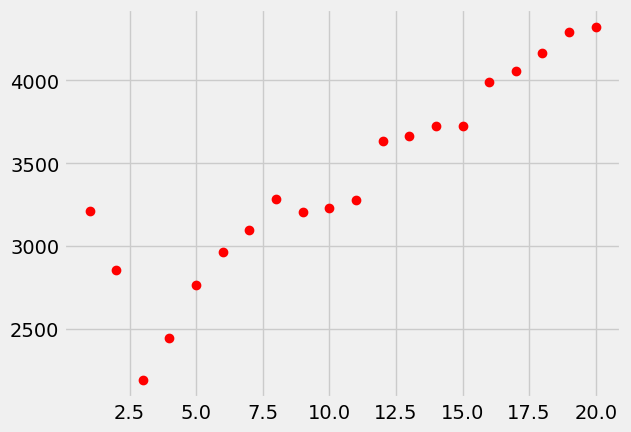

In [ ]:
class RegressionDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=4):
        super().__init__()
        self.batch_size = batch_size
        self.x_train = torch.tensor([[i] for i in range(1, 21)], dtype=torch.float).view(-1, 1)
        self.y_train = torch.tensor([[3214], [2855], [2191], [2447], [2766], [2965],
                                      [3101], [3284], [3209], [3233], [3279],
                                      [3633], [3662], [3725], [3723], [3992], [4056], [4164], [4289], [4322]], dtype=torch.float).view(-1, 1)
    # dataset creation
    def setup(self, stage=None):
        self.dataset = TensorDataset(self.x_train, self.y_train)

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size)

    def full_train_dataloader(self):
        return DataLoader(self.dataset, batch_size=len(self.x_train))

    # def val_dataloader(self):
    #     return DataLoader(self.dataset, batch_size=self.batch_size)

    # def test_dataloader(self):
    #     return DataLoader(self.dataset, batch_size=self.batch_size)

plt.plot(RegressionDataModule().x_train, RegressionDataModule().y_train, 'ro')
plt.show()

## Module =  design the model

In [ ]:
class LinearRegressionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.linear = Linear(1, 1)
        self.loss_fn = MSELoss()
        self.save_hyperparameters()   # saves checkpoints during training

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     x, y = batch
    #     y_hat = self(x)
    #     val_loss = self.loss_fn(y_hat, y)
    #     self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    #     return val_loss

    # def test_step(self, batch, batch_idx):
    #     x, y = batch
    #     y_hat = self(x)
    #     test_loss = self.loss_fn(y_hat, y)
    #     self.log('test_loss', test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    #     return test_loss

    def predict_step(self, batch, batch_idx):
        x, _ = batch  # ignoring y since we only need to make predictions
        y_hat = self(x)  # using the forward function
        return y_hat

    def configure_optimizers(self):
        return SGD(self.parameters(), lr=0.001)

    def plot_fit(self, x, y, y_hat):
        plt.plot(x.cpu().numpy(), y.cpu().numpy(), 'ro', label='Original data')
        plt.plot(x.cpu().numpy(), y_hat.cpu().numpy(), label='Fitted line')
        plt.legend()
        plt.show()

## Trainer = train the model

**Logger**

A logger in PyTorch Lightning is a utility that records and stores information about your training process, such as metrics at each step. This information can be written to a file, displayed in the console, or sent to visualization tools like TensorBoard, WandB, or simple CSV file. By default, PyTorch Lightning uses the TensorBoard logger if no logger is specified when initializing the Trainer. Multiple loggers can also be used at the same time.

In [ ]:
logger = CSVLogger("logs", name="LinearRegression")

**Train**

In [ ]:
# Initialize the model and data module
model = LinearRegressionModel()
data_module = RegressionDataModule()

# Get the number of available GPUs, else use CPU
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

# Train and Validate the model
trainer = pl.Trainer(logger=logger, devices=ngpus, accelerator='auto', max_epochs=1000)
trainer.fit(model, data_module)
# trainer.test(model, datamodule=data_module)


INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | linear  | Linear  | 2      | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


**Check the training**

In [ ]:
log_file = 'logs/LinearRegression/version_0/metrics.csv'
df = pd.read_csv(log_file)
df

,epoch,step,train_loss
0,0,4,5.912297e+06
1,1,9,1.690428e+06
2,2,14,1.530990e+06
3,3,19,1.510712e+06
4,4,24,1.502082e+06
...,...,...,...
995,995,4979,6.426392e+04
996,996,4984,6.420855e+04
997,997,4989,6.415340e+04
998,998,4994,6.409857e+04


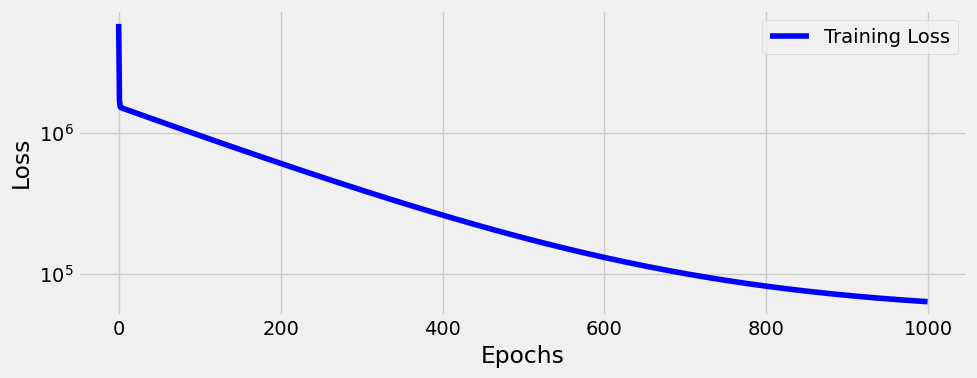

In [ ]:
def plot_csv_losses(df):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(df['epoch'], df['train_loss'], label='Training Loss', c='b')
    #plt.plot(df['epoch'], df['val_loss_epoch'], label='Validation Loss', c='r') # Uncomment this when validation loss is available
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

plot_csv_losses(df)

## Prediction

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

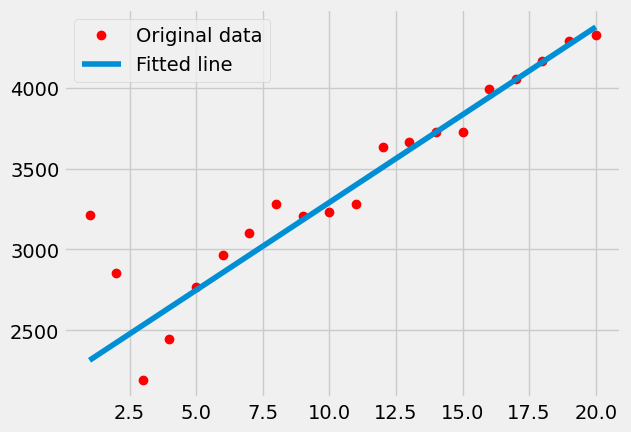

In [ ]:
# Use the trained model to make predictions
predictions = trainer.predict(model, data_module.full_train_dataloader())

# Plot the original data and the fitted line
model.plot_fit(data_module.x_train, data_module.y_train, predictions[0])

## Save and Resume
Lightning automatically saves a checkpoint of your last training epoch in your current directory, allowing you to resume training if interrupted.

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

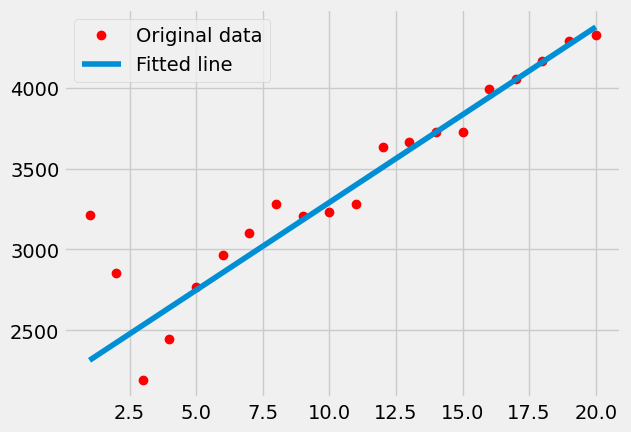

In [ ]:
pretrained_model = LinearRegressionModel.load_from_checkpoint('/content/logs/LinearRegression/version_0/checkpoints/epoch=999-step=5000.ckpt')
predictions = trainer.predict(pretrained_model, data_module.full_train_dataloader())
model.plot_fit(data_module.x_train, data_module.y_train, predictions[0])

## Wandb logger

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True


> *If you get wandb ModuleNotFoundError > Restart colab runtime.*




INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: s-drocarova. Use `wandb login --relogin` to force relogin


INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | linear  | Linear  | 2      | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
train_loss,██▇▆▆▅▅▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
epoch,999
train_loss,64049.17578
trainer/global_step,4999


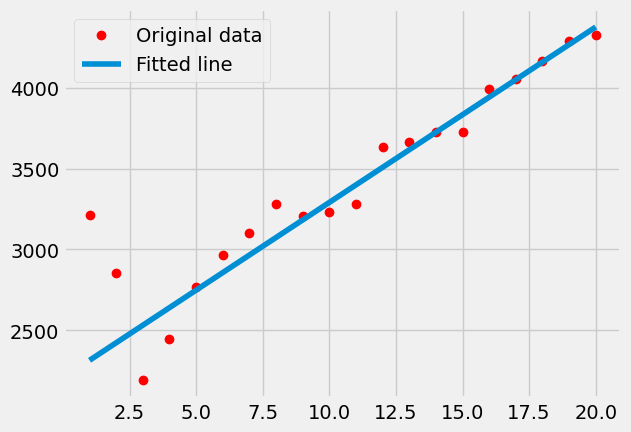

In [ ]:
the_same_model = LinearRegressionModel()
logger = WandbLogger(project="Lab2-LinReg")
trainer = pl.Trainer(logger=logger, devices=ngpus, accelerator='auto', max_epochs=1000,log_every_n_steps=3)
trainer.fit(the_same_model, data_module)
predictions = trainer.predict(the_same_model, data_module.full_train_dataloader())

# Log the prediction figure
plt.plot(data_module.x_train.cpu().numpy(), data_module.y_train.cpu().numpy(), 'ro', label='Original data')
plt.plot(data_module.x_train.cpu().numpy(), predictions[0].cpu().numpy(), label='Fitted line')
plt.legend()
plt.savefig("prediction_figure.png")
wandb.log({"Prediction Figure": wandb.Image(Image.open("prediction_figure.png"))})

# Finish W&B is important in Colab
wandb.finish()

## ✍🏼 Exercise 1
**How would you run training on 4 GPUs?**

*Your answer: trainer = pl.Trainer(logger=logger, devices=4,accelerator='gpu',strategy='ddp',max_epochs=1000)

## Recap

Let's ensure we're on the same page. In our last lesson (Lab 1), we learned how to:

* **Prepare data for our model**: Before any computation, data needs to be prepared. In the PyTorch Lightning framework, we created a `RegressionDataModule` class. This class manages data loading and allows us to split our data into training, validation, and test sets and data loaders, a crucial step to setting up our machine learning pipeline.

* **Send data to the GPU**: In PyTorch Lightning, this process is automatically handled. When you specify `accelerator="gpu", devices=N` in the `Trainer`, the prepared data and model are automatically sent to the available GPUs for efficient computation.

* **Train our model**: In PyTorch Lightning, the training of the model is an essential phase. It streamlines this by replacing the traditional training loop with the `Trainer.fit()` function. The training step is defined in the `training_step()` method, where predictions are made and loss is calculated.

 * **Make predictions (P)**: In the `training_step()` method of a PyTorch Lightning module, you define how to make predictions with your model. This is done with `self(x)` where `self` calls the `forward()` method of your LightningModule, and `x` is your input data.

 * **Compute the loss (L)**: The loss computation is also done in the `training_step()`. After making predictions, we calculate the loss typically with `self.loss_fn(y_hat, y)` where `y_hat` is your prediction and `y` is the target.

 * **Compute the gradients (G)**: The backward pass to compute gradients is automatically handled by PyTorch Lightning after the `training_step()`.

 * **Update the parameters (U)**: The optimizer step is automatically performed by PyTorch Lightning after gradients are computed. You define what optimizer to use in the `configure_optimizers()` method.

* **Improve training with mini-batches**: PyTorch Lightning handles mini-batches when you pass a `DataLoader` to `Trainer.fit()`. This aids in the optimization of our model training.

* **Add validation and testing loops**: We can optionally define `validation_step` and `test_step` in our LightningModule. These methods define the operations conducted during the validation and testing phase of our model training. To run the validation loop, pass in the validation set to `.fit` method: `trainer.fit(model, train_loader, valid_loader)`. Once the model has finished training, call `trainer.test()`.

* **Track and visualize the training process**: The `CSVLogger` provided in the code logs the metrics of the training process into a CSV file. This allows for easy tracking and visualization of the training process. However, this `CSVLogger` could be replaced by more advanced tools like TensorBoard or Weights & Biases for a more detailed analysis.

* **Save and load our model**: PyTorch Lightning also has the functionality to automatically save checkpoints during the model training. This allows for the training process to be resumed if it gets interrupted, or for the model to be reused later. The `load_from_checkpoint()` function can be used to load these checkpoints.

* **Use trained model to predict new data**: Finally, once our model is trained, we can use it to make predictions on new data. You can define a `predict()` method in your LightningModule, but you can also directly use the model for inference in PyTorch Lightning with `model.eval()` and `model(x)`.

By understanding and implementing these steps, you will be able to effectively train and use a machine learning model using PyTorch Lightning.


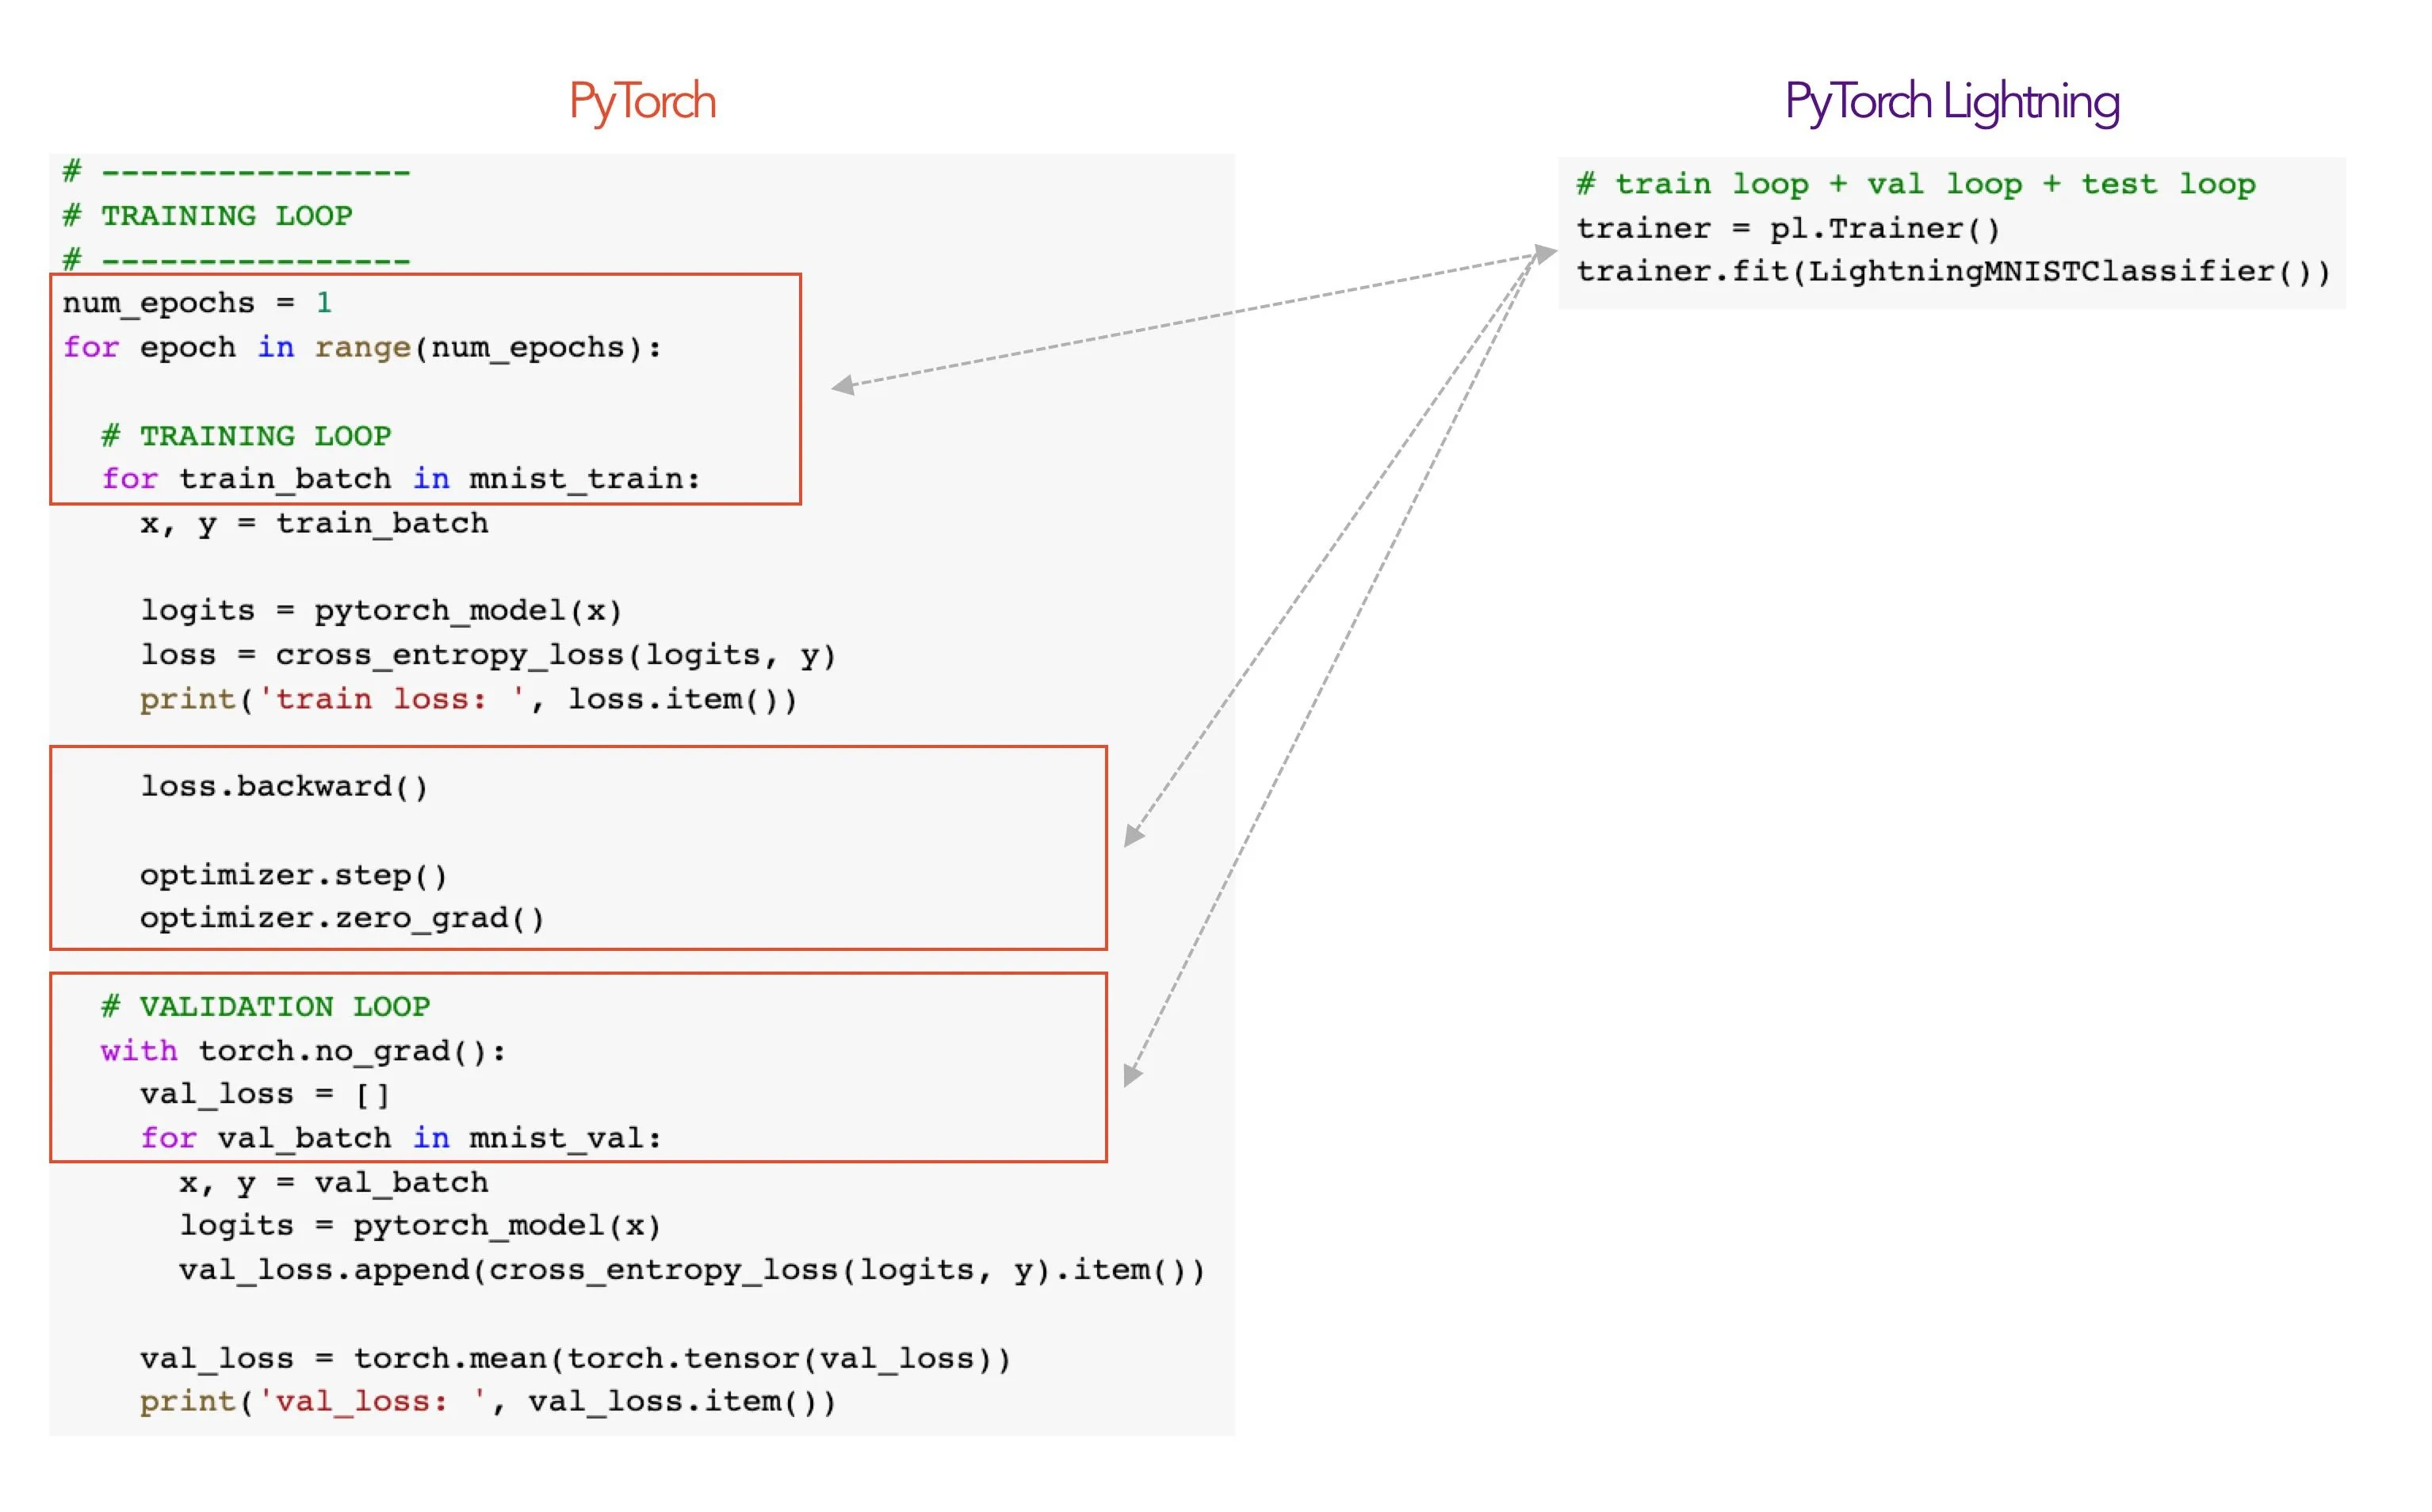

# Part 2: Overfitting



<img src="https://su2.utia.cas.cz/files/labs/23-202/overfit.jfif">
<br /><br />

We will demonstrate overfitting on linearly generated data (lying on a line + noise)

$$
\Large y = w x + b + \epsilon
$$

but modeled by polynomial regression 4th order.

$$
\Large \hat{y} =  b + w_1 x + w_2 x^2 + w_3 x^3 + w_4 x^4
$$

The easiest way how to implement polynomial regression is to expand our training data

$x \qquad \rightarrow \qquad [x^1,x^2,x^3,x^4]$

and then implement linear layer with 4 inputs `torch.nn.Linear(4, 1)`. This corresponds to:

$ \hat{y} =  b + w_1 x + w_2 x^2 + w_3 x^3 + w_4 x^4$

<br />

😎 We use method `.pow(4)` which returns the value of x raised to power of 4




## Data: Prepare and Split

In [ ]:
class PolynomialRegressionDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=4, order=4):
        super().__init__()
        self.batch_size = batch_size
        self.order = order

        # Generate the data
        np.random.seed(42)
        true_w = 2
        true_b = 1
        N = 8  # Number of data points
        x = np.random.rand(N, 1)  # Generate N random values for x
        epsilon = (.1 * np.random.randn(N, 1))
        y = true_b + true_w * x + epsilon # Generate y values
        # split data into training and validation set
        idx = np.arange(N)
        np.random.shuffle(idx)
        train_idx = idx[:4]
        val_idx = idx[4:]
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        x_train_tensor = torch.from_numpy(x_train).float()
        y_train_tensor = torch.from_numpy(y_train).float()
        x_val_tensor = torch.from_numpy(x_val).float()
        y_val_tensor = torch.from_numpy(y_val).float()

        # Expand data x -> [x^1,x^2,x^3,x^4,...]
        p = torch.tensor(range(1, self.order+1))
        self.x_train_tensor_pow = x_train_tensor.pow(p) # Matrix size 4 x order
        self.x_val_tensor_pow = x_val_tensor.pow(p)
        self.y_train_tensor = y_train_tensor
        self.y_val_tensor = y_val_tensor

    def setup(self, stage=None):
        # in setup we build the datasets
        self.train_dataset = TensorDataset(self.x_train_tensor_pow, self.y_train_tensor)
        self.val_dataset = TensorDataset(self.x_val_tensor_pow, self.y_val_tensor)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


## Model: Design

In [ ]:
class PolynomialRegressionModel(pl.LightningModule):
    def __init__(self, order=4):
        super().__init__()
        self.linear = Linear(order, 1)
        self.loss_fn = MSELoss()

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.loss_fn(y_hat, y)
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return val_loss

    def configure_optimizers(self):
        return SGD(self.parameters(), lr=0.1)

## Model: Train

<b>Set up the order of polynomial regression:</b>

*   order = 4 (overfitting)
*   order = 1 (good model)




In [ ]:
order = 4

# Initialize the model and data module
model = PolynomialRegressionModel(order=order)
data_module = PolynomialRegressionDataModule(order=order, batch_size=4)

# Get the number of available GPUs, else use CPU
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

# Train and Validate the model
trainer = pl.Trainer(logger=CSVLogger("logs", name="PolynomialRegression"), devices=ngpus, max_epochs=100, log_every_n_steps=1)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | linear  | Linear  | 5      | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


🤔 *What are these 5 trainable parameters?*

$... [b, w_1, w_2, w_3, w_4]$

**Check the training**

In [ ]:
log_file = '/content/logs/PolynomialRegression/version_0/metrics.csv'
df = pd.read_csv(log_file)
df_grouped = df.groupby('epoch').first().reset_index()
df_grouped

,epoch,step,train_loss,val_loss
0,0,0,4.847005,2.189676
1,1,1,1.753538,1.160526
2,2,2,0.646737,0.699209
3,3,3,0.249337,0.477692
4,4,4,0.105409,0.363688
...,...,...,...,...
95,95,95,0.000181,0.150008
96,96,96,0.000181,0.150007
97,97,97,0.000180,0.150007
98,98,98,0.000180,0.150008


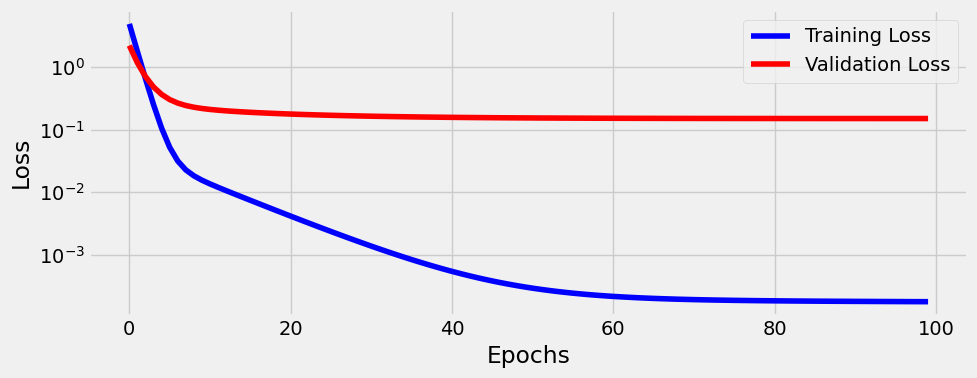

In [ ]:
def plot_csv_losses(df_cleaned):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(df_cleaned['epoch'], df_cleaned['train_loss'], label='Training Loss', c='b')
    plt.plot(df_cleaned['epoch'], df_cleaned['val_loss'], label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_csv_losses(df_grouped)

❗ So, in the case of overfitting, the training loss is often very low, while the validation/test loss is much higher. This discrepancy is a key indication of overfitting.

## Prediction: Make and Evaluate

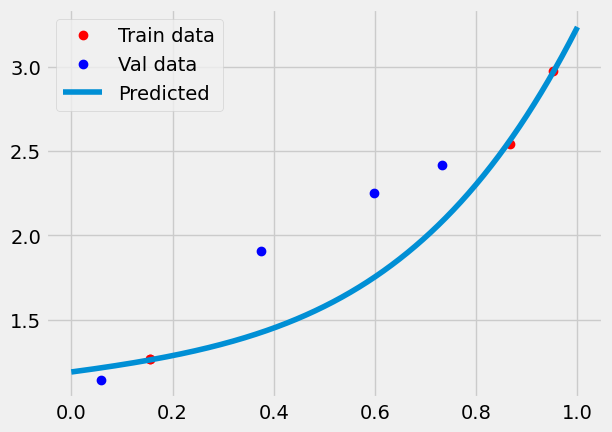

In [ ]:
# after the trainer.fit call
# Get the data
x_train = data_module.x_train_tensor_pow.cpu().numpy()
y_train = data_module.y_train_tensor.cpu().numpy()
x_val = data_module.x_val_tensor_pow.cpu().numpy()
y_val = data_module.y_val_tensor.cpu().numpy()

# Get the model device (either cpu or cuda)
device = next(model.parameters()).device

# Generate new points for prediction
xx = np.linspace(0, 1.0, num=1000).reshape(1000,1)
xx_tensor = torch.from_numpy(xx).float()
p = torch.tensor(range(1, order+1))
xx_tensor = xx_tensor.pow(p)

# Pass through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Don't track gradients
    xx_tensor = xx_tensor.to(device)  # Move to device
    predicted = model(xx_tensor)
predicted = predicted.cpu().numpy()

# Plot the data
plt.plot(x_train[:,0], y_train, 'ro', label='Train data')
plt.plot(x_val[:,0], y_val, 'bo', label='Val data')
plt.plot(xx, predicted, '-', label='Predicted')
plt.legend()
plt.show()



❗ Order = 4 $\qquad \rightarrow \qquad $ Our model was too complex and overfitted our training data.

![](https://ml2.utia.cas.cz/files/labs/23-202/chat2.png)

## ✍🏼 Exercise 2

Overfitting is a common problem in machine learning where a model performs well on the training data but poorly on the test or unseen data. This is typically due to the model learning the noise in the training data. There are several strategies to mitigate overfitting when designing neural network architectures, such as:

*   Regularization
*   Dropout
*   Data augmentation
*   Early stopping
*   Reducing the complexity of the model
*   Batch normalization
*   Ensemble methods

🤔 **Provide a brief description for each of these terms.**

*Your answer:
*   Regularization - L1 = adds abs. vals of weights or L2 = adds sqr. vals of weights
*   Dropout - random deactivation of neurons with some predifed probability
*   Data augmentation - using transformations for the creation of additional data
*   Early stopping - stopping after the the performance on validation data is not improving
*   Reducing the complexity of the model - simplifying the models structure - reducing the number of layers/ width of the layers
*   Batch normalization - stabilizes the distribution of layer inputs, adjusts the input to zero mean and std within minibatches
*   Ensemble methods - combining more models together, preferably they should have different strucutres, consequently capturing different features from the data -> some voting or max decisions

🤔 **Which of these strategies would you employ in the above code to mitigate overfitting?**

*Your answer: reducing complexity

# Part 3: Image classification

## Rock Paper Scissors Dataset

>This dataset was created by Laurence Moroney (lmoroney@gmail.com / [laurencemoroney.com](http://www.laurencemoroney.com)) and can be found in his site: [Rock Paper Scissors Dataset](https://huggingface.co/datasets/jerpint/rock-paper-scissors).

>The dataset is licensed as Creative Commons (CC BY 2.0). No changes were made to the dataset.

*Rock Paper Scissors contains images from various hands, from different races, ages, and genders, posed into Rock / Paper or Scissors and labeled as such. You can download the [training set here](https://huggingface.co/datasets/jerpint/rock-paper-scissors/resolve/main/rps.zip) (2,520 images) and the [test set here](https://huggingface.co/datasets/jerpint/rock-paper-scissors/resolve/main/rps-test-set.zip) (372 images). Images were created using CGI techniques as an experiment in determining if a model trained on a CGI-based dataset could classify real images.*

*Note that all of these pictures use a plain white background. Each image is 300×300 pixels in 24-bit color.*

RPS dataset is perfectly balanced, each sub-folder contain 840 images of its
particular class.

![](https://ml2.utia.cas.cz/files/labs/23-202/rps.png)

❗ Balanced datasets are preferred in machine learning because they prevent bias towards the majority class, ensure better learning from all classes, and provide more accurate performance metrics. Imbalanced data can lead to models favoring the majority class and providing misleading accuracy.

## Load packages

In [ ]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, \
ToPILImage, Resize
from torchvision.datasets import ImageFolder

## Data: Prepare and Split

### Download dataset
Let's proceed to download the Rock-Paper-Scissors dataset and extract its contents into the default `content` folder.

![](https://ml2.utia.cas.cz/files/labs/23-202/rps-fold.png)

In [3]:
import requests
import zipfile
import os
import errno
import matplotlib.pyplot as plt

filenames = ['rps.zip', 'rps-test-set.zip']
for filename in filenames:
    try:
        os.mkdir(f'{filename[:-4]}')

        localfile = f'{filename}'
        url = 'https://huggingface.co/datasets/jerpint/rock-paper-scissors/resolve/main/{}'
        r = requests.get(url.format(filename), allow_redirects=True)
        open(localfile, 'wb').write(r.content)
        with zipfile.ZipFile(localfile, 'r') as zip_ref:
            zip_ref.extractall("")
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
        else:
            print(f'{filename[:-4]} folder already exists!')



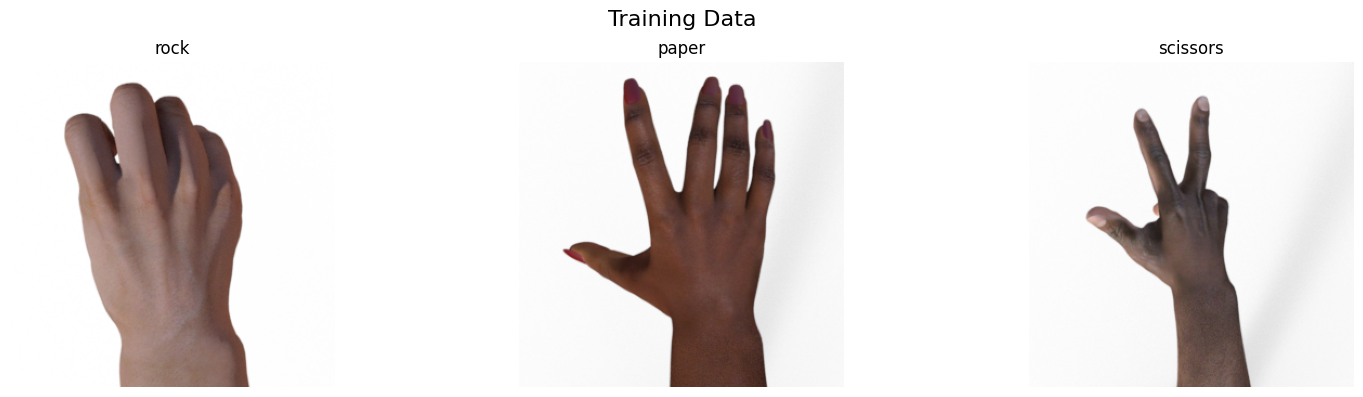

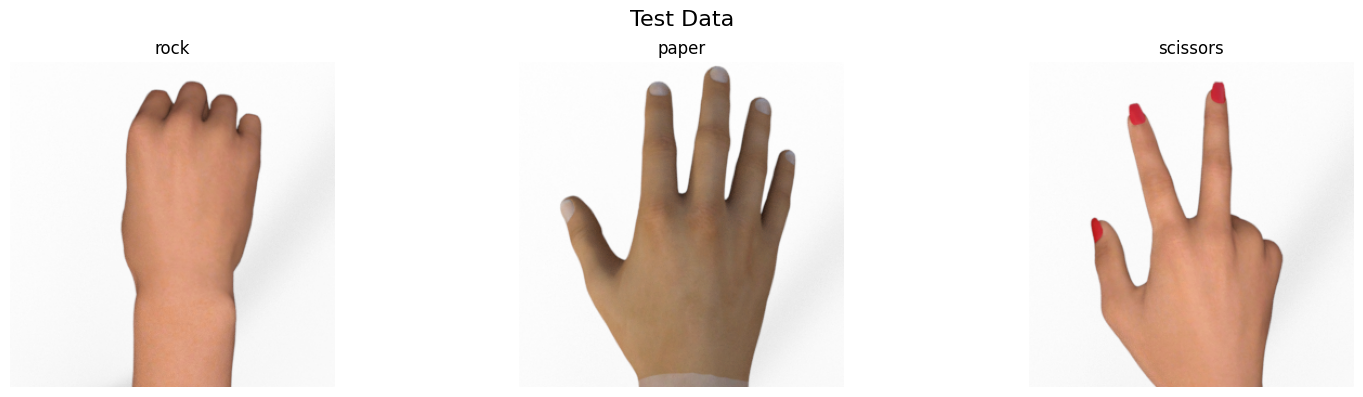

In [4]:
import matplotlib.image as mpimg

# Function to load and plot one image from each subdirectory (class)
def plot_one_sample_per_class(folder, title):
    # Get the class subdirectories inside the folder
    subdirs = [os.path.join(folder, subdir) for subdir in os.listdir(folder) if os.path.isdir(os.path.join(folder, subdir))]

    fig, axes = plt.subplots(1, len(subdirs), figsize=(16, 4))

    # Add a title to indicate train or test data
    fig.suptitle(title, fontsize=16)

    for i, subdir in enumerate(subdirs):
        # Pick the first image from each class subdirectory
        image_files = os.listdir(subdir)
        if len(image_files) > 0:
            img_path = os.path.join(subdir, image_files[0])  # First image in the folder
            img = mpimg.imread(img_path)

            # Display the image
            axes[i].imshow(img)
            axes[i].axis('off')  # Hide the axes
            axes[i].set_title(os.path.basename(subdir))  # Set the class name as title

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the top spacing for the header
    plt.show()

# Define the folder paths
train_folder = 'rps'
test_folder = 'rps-test-set'

# Plot one sample from each class in the train folder
plot_one_sample_per_class(train_folder, "Training Data")

# Plot one sample from each class in the test folder
plot_one_sample_per_class(test_folder, "Test Data")


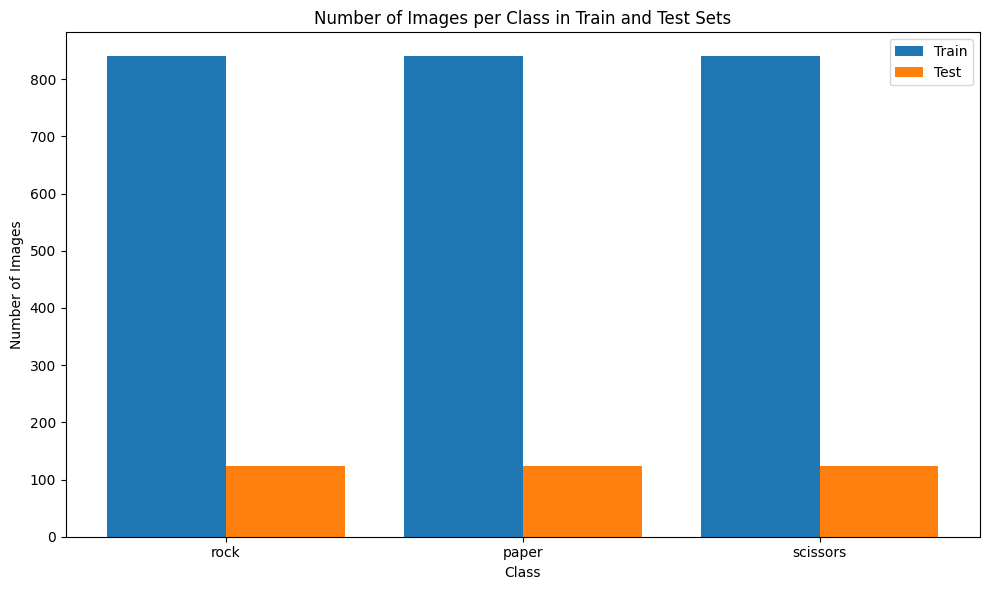

In [5]:

# Function to count the number of images in each class (subdirectory)
def count_images_per_class(folder):
    class_counts = {}
    # Get all subdirectories (classes)
    subdirs = [subdir for subdir in os.listdir(folder) if os.path.isdir(os.path.join(folder, subdir))]

    for subdir in subdirs:
        subdir_path = os.path.join(folder, subdir)
        image_files = os.listdir(subdir_path)
        class_counts[subdir] = len(image_files)

    return class_counts


# Count images for each class in the train and test sets
train_counts = count_images_per_class(train_folder)
test_counts = count_images_per_class(test_folder)

# Plot the data as a bar graph
def plot_class_distribution(train_counts, test_counts):
    labels = list(train_counts.keys())  # Class labels
    train_values = list(train_counts.values())  # Number of images in train set
    test_values = list(test_counts.values())  # Number of images in test set

    x = range(len(labels))  # X-axis positions

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars for train and test data
    ax.bar(x, train_values, width=0.4, label='Train', align='center')
    ax.bar([i + 0.4 for i in x], test_values, width=0.4, label='Test', align='center')

    # Add labels and title
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images per Class in Train and Test Sets')
    ax.set_xticks([i + 0.2 for i in x])  # Center labels
    ax.set_xticklabels(labels)

    ax.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the graph
plot_class_distribution(train_counts, test_counts)


### Normalize dataset

For optimal performance of gradient descent, it's beneficial to keep input features within manageable ranges.

We'll apply normalization (specifically, standardization) to achieve this. This process entails subtracting the mean value and then dividing by the standard deviation.

First, we need to create a function that calculates statistics per channel.



In [6]:
def statistics_per_channel(images):
    n_samples, n_channels, n_height, n_weight = images.size()
    # Flatten Height and Width into a single dimension
    flatten_per_channel = images.reshape(n_samples, n_channels, -1)
    # Computes statistics of each image per channel
    # Average pixel value per channel
    # (n_samples, n_channels)
    means = flatten_per_channel.mean(axis=2)
    # Standard deviation of pixel values per channel
    # (n_samples, n_channels)
    stds = flatten_per_channel.std(axis=2)

    # Adds up statistics of all images in a mini-batch
    # (1, n_channels)
    sum_means = means.sum(axis=0)
    sum_stds = stds.sum(axis=0)
    # Makes a tensor of shape (1, n_channels)
    # with the number of samples in the mini-batch
    n_samples = torch.tensor([n_samples]*n_channels).float()
    # Stack the three tensors on top of one another
    # (3, n_channels)
    return torch.stack([n_samples, sum_means, sum_stds], axis=0)

...and finally our normalized Rock-paper-scissors Pytorch lightning data module

In [9]:
class ImageDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=16):
        super().__init__()
        self.batch_size = batch_size
        self.train_dir = 'rps'
        self.test_dir = 'rps-test-set'
        self.composer = None

    def setup(self, stage=None):
        # Load dataset and build normalizer
        temp_transform = Compose([Resize(28), ToTensor()])
        temp_dataset = ImageFolder(root=self.train_dir, transform=temp_transform)
        temp_loader = DataLoader(temp_dataset, batch_size=self.batch_size)

        results = [statistics_per_channel(x) for i, (x, y) in enumerate(temp_loader)]
        results = torch.stack(results, axis=0) # collecting statistics for each batch of images
        total_samples, total_means, total_stds = results.sum(axis=0)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples

        normalizer = Normalize(mean=norm_mean, std=norm_std)

        # Build transformation, datasets and data loaders
        self.composer = Compose([Resize(28), ToTensor(), normalizer])
        self.train_data = ImageFolder(root=self.train_dir, transform=self.composer)
        self.val_data = ImageFolder(root=self.test_dir, transform=self.composer)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)


❗ Always use the training set for computing statistics for normalization!

`ImageFolder()` is a pytorch generic dataset if your images are sorted into class-named sub-folders.

![](https://ml2.utia.cas.cz/files/labs/23-202/rps2.png)

The `transform` argument in `ImageFolder()` applies desired modifications to images.

To speed up training, we shrank images to 28x28 pixels using `Resize(28)` and changed them into PyTorch's tensors with `ToTensor()`.

We utilized `statistics_per_channel()` to compute the average mean and standard deviation, and applied `Normalize()` to standardize our dataset.

How does the training set has changed after normalization?

NameError: name 'ToPILImage' is not defined

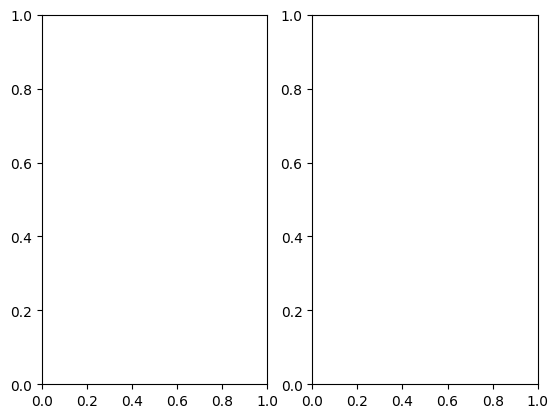

In [12]:
data_module = ImageDataModule()
data_module.setup()
train_data_no_norm = ImageFolder(root='rps', transform=Compose([Resize(28),ToTensor()]))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.grid(False)
ax1.imshow(ToPILImage()(train_data_no_norm[0][0]))
ax2.grid(False)
ax2.imshow(ToPILImage()(data_module.train_data[0][0]))

🤔 "What’s wrong with the colors?"

Nothing, it is just the effect of the normalization (standardization) of the pixel values.

## Model: Design and Train

The `CNNModel` class is a PyTorch Lightning module that encapsulates a Convolutional Neural Network (CNN) for our image classification tasks.

The network architecture is defined in the `__init__` method. It consists of two main components: the featurizer and the classifier.

1. **Featurizer**: This part of the network is responsible for extracting relevant features from the input images. It's composed of two convolutional layers (`conv1` and `conv2`) with ReLU activations and max pooling operations.

2. **Classifier**: After the featurization stage, the extracted features are passed through the classifier, which is a simple feed-forward neural network. The classifier contains two fully connected layers (`fc1` and `fc2`), with ReLU activation after `fc1`. Dropout is applied after both fully connected layers if the dropout probability `p` is greater than 0.

The `forward` method implements the forward pass of the network, taking an input tensor `x`, passing it through the featurizer and classifier, and returning the output tensor.

The `training_step` and `validation_step` methods define what happens in each step of the training and validation phase, respectively. In each step, the loss is calculated using the Cross-Entropy Loss and then logged.

Finally, the `configure_optimizers` method specifies the optimizer to be used during the training phase. In this case, we are using SGD with momentum and Nesterov's accelerated gradient.


In [ ]:
class CNNModel(pl.LightningModule):
    def __init__(self, n_feature=5, p=0.5):
        super().__init__()
        self.n_feature = n_feature
        self.p = p
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)
        self.drop = nn.Dropout(self.p)
        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

    def featurizer(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

🤔 What is `nesterov=True`?

**Dimensions of Data Through CNNModel:**<br />


> Input: 28x28x3 <br />
After conv1: 26x26x5 <br />
After Max Pooling: 13x13x5 <br />
After conv2: 11x11x5 <br />
After Max Pooling: 5x5x5 <br />
After Flatten: 125 <br />
After fc1: 50 <br />
After fc2: 3 <br />




### Train the network
It will last aprox. 2 minutes on usual Colab GPU.

In [ ]:
# Initialize the model and data module
model = CNNModel(n_feature=5, p=0.5)
data_module = ImageDataModule()

# Get the number of available GPUs, else use CPU
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

logger = CSVLogger("logs", name="RockPaperScissors")

# Train and Validate the model
trainer = pl.Trainer(logger=CSVLogger("logs", name="RockPaperScissors"), devices=ngpus, accelerator='auto', max_epochs=10)
trainer.fit(model, data_module)


INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv2d           | 140    | train
1 | conv2   | Conv2d           | 230    | train
2 | fc1     | Linear           | 6.3 K  | train
3 | fc2     | Linear           | 153    | train
4 | drop    | Dropout          | 0      | train
5 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)
6         Modules in train mode
0         Modules 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


🤔 Why does `conv1` has `140` learnable parameters and `conv2` have `230`?


```
# = (in_channels * out_channels * kernel_size * kernel_size) + (out_channels * 1)
```



**Check the training**

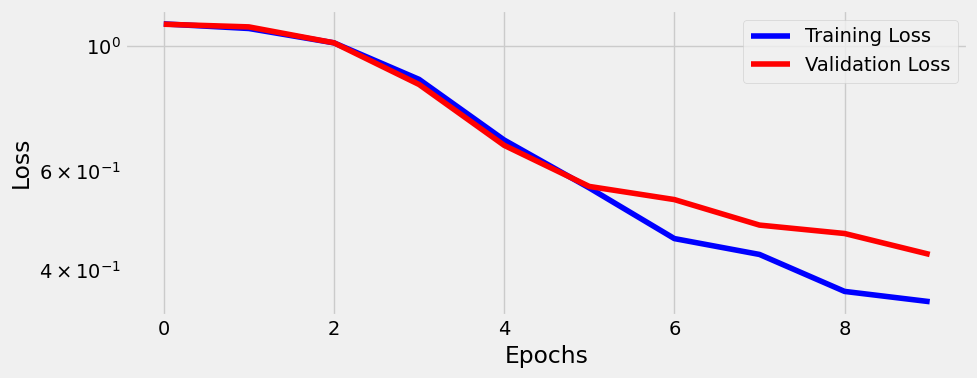

In [ ]:
log_dir = 'version_0'

def plot_csv_losses(df_cleaned):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(df_cleaned['epoch'], df_cleaned['train_loss'], label='Training Loss', c='b')
    plt.plot(df_cleaned['epoch'], df_cleaned['val_loss'], label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

log_file = f'/content/logs/RockPaperScissors/{log_dir}/metrics.csv'
df = pd.read_csv(log_file)
df_grouped = df.groupby('epoch').first().reset_index()
plot_csv_losses(df_grouped)

## Prediction: Make and Evaluate

In [ ]:
def correct(model, loader):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device

    results = []
    for batch in loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        y_hat = model(x)

        _, n_dims = y_hat.shape
        _, predicted = torch.max(y_hat, 1)

        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            results.append((n_correct, n_class))

    model.train()  # Set the model back to training mode

    return torch.tensor(results)

train_results = correct(model, data_module.train_dataloader())
train_results = train_results.sum(axis=0)
print(f'The training set: our model got {train_results[0]} out of {train_results[1]} images correctly classified, an accuracy of {train_results[0]/train_results[1]*100:.2f}%!')

val_results = correct(model, data_module.val_dataloader())
val_results = val_results.sum(axis=0)
print(f'The validation set: our model got {val_results[0]} out of {val_results[1]} images correctly classified, an accuracy of {val_results[0]/val_results[1]*100:.2f}%!')


The training set: our model got 2494 out of 2520 images correctly classified, an accuracy of 98.97%!
The validation set: our model got 296 out of 372 images correctly classified, an accuracy of 79.57%!


🤔 **Implement dropout with a probability of 0 (p=0) and discuss the implications.**



## CNN Autopsy: Scalpel to the Featurizer

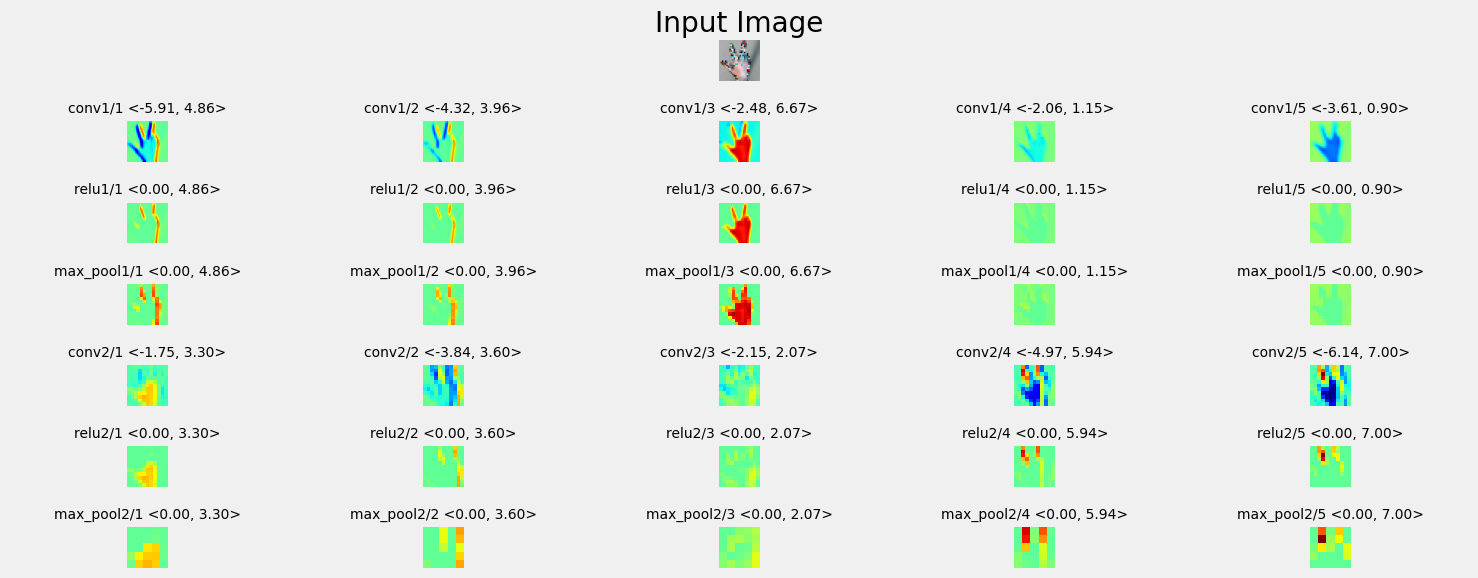

In [ ]:
def visualize_feature_maps(model, x):
    visualizations = []
    layer_names = []
    x = model.conv1(x)
    visualizations.append(x)
    layer_names.append('conv1')
    x = F.relu(x)
    visualizations.append(x)
    layer_names.append('relu1')
    x = F.max_pool2d(x, kernel_size=2)
    visualizations.append(x)
    layer_names.append('max_pool1')
    x = model.conv2(x)
    visualizations.append(x)
    layer_names.append('conv2')
    x = F.relu(x)
    visualizations.append(x)
    layer_names.append('relu2')
    x = F.max_pool2d(x, kernel_size=2)
    visualizations.append(x)
    layer_names.append('max_pool2')
    return visualizations, layer_names

# get a batch of data
images, labels = next(iter(data_module.train_dataloader()))

# select the first image in the batch
image = images[0].unsqueeze(0)

# pass the image through the visualization function
visualizations, layer_names = visualize_feature_maps(model, image.to(model.device))

# move the visualizations back to the cpu and detach them from the computation graph
visualizations = [v.detach().cpu() for v in visualizations]

# get number of feature maps
n_features = visualizations[0].shape[1]

# plot the feature maps
fig, axes = plt.subplots(nrows=len(visualizations) + 1, ncols=n_features, figsize=(15,6))

# plot the input image
input_image = image.squeeze(0).cpu()
axes[0, n_features//2].imshow(ToPILImage()(input_image))
axes[0, n_features//2].set_title('Input Image')
axes[0, n_features//2].axis('off')

# hide other axes in first row
for ax in axes[0, :]:
    if ax != axes[0, n_features//2]:
        ax.axis('off')

# Compute global min and max across all feature maps for consistent color mapping
global_min = min([v.min().item() for v in visualizations])
global_max = max([v.max().item() for v in visualizations])

for v in range(len(visualizations)):
    for i, ax in enumerate(axes[v + 1, :]):
        # plot feature map i
        feature_map = visualizations[v][0,i,:,:]
        im = ax.imshow(feature_map, cmap='jet', vmin=global_min, vmax=global_max)
        min_val = feature_map.min().item()
        max_val = feature_map.max().item()
        ax.set_title(f'{layer_names[v]}/{i+1} <{min_val:.2f}, {max_val:.2f}>', fontsize=10)
        ax.axis('off')


plt.tight_layout()
plt.show()


😕 Still confused? This can help:

*   [2D visualization](https://adamharley.com/nn_vis/cnn/2d.html)
*   [3D visualization](https://adamharley.com/nn_vis/cnn/3d.html)


# Part 4: Transfer learning

![RPS](https://su2.utia.cas.cz/files/labs/23-202/rpsrps.png)

We're going to revisit our task of classifying images in the Rock-Paper-Scissors dataset. However, this time we're going to use a technique called Transfer Learning.

**Transfer Learning Explained**

Consider having a model that's already trained and highly efficient at identifying objects in a broad collection of images, such as those in the [ImageNet](https://www.image-net.org/) dataset. Now, your new task is to classify images of rock-paper-scissors.

Instead of starting from scratch - training a new model on this specific task, we take a shortcut. We take the ImageNet-trained model and ensure that it retains its proficiency in recognizing features in images (this is known as freezing the featurizer). Then, we adjust this model's purpose - from recognizing general objects to specifically categorizing rock-paper-scissors images (we modify and train the classifier).

This is the essence of transfer learning. It is an efficient approach, leveraging pre-existing knowledge to adapt to a new, but related task.

![Transfer learning](https://su2.utia.cas.cz/files/labs/23-202/trans2.jpg)

**The easiest way how to demonstrate Transfer learning is to use one of the famous architectures for image classification**
![Architectures](https://su2.utia.cas.cz/files/labs/23-202/arch2.png)

![Architectures 2](https://su2.utia.cas.cz/files/labs/23-202/download.png)

*Source: Data for accuracy and GFLOPs estimates obtained from [this](https://github.com/albanie/convnet-burden) report, number of parameters proportional to the size of the circles obtained from Torchvision’s models.*

In [ ]:
from torchvision.models import alexnet
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torchvision.transforms import CenterCrop
import torchvision.transforms as transforms

## Pre-Trained Alexnet Model
![Alexnet](https://su2.utia.cas.cz/files/labs/23-202/alexpng3.png)

In [ ]:
alex = alexnet(pretrained=False)
print(alex)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

The element in the middle, `AdaptiveAvgPool2d` (`F.adaptive_avg_pool2d` in its
functional form), is a special kind of pooling: instead of requiring the kernel size
(and stride), it requires the desired output size. In other words, whatever the
image size it gets as input, it will return a tensor with the desired size.

### Loading Weights

Of course we could use `alexnet(pretrained=True)`, but let us demonstrate how to load weights from different location.

In [ ]:
url = 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth'
state_dict = load_state_dict_from_url(url, model_dir='./pretrained', progress=True)
alex.load_state_dict(state_dict)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to ./pretrained/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 305MB/s]


<All keys matched successfully>

### Model Freezing

In [ ]:
def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

freeze_model(alex)

### Top of the Model

In [ ]:
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
torch.manual_seed(11)
alex.classifier[6] = nn.Linear(4096, 3)

![Logo 203](https://su2.utia.cas.cz/files/labs/23-202/alexnet.png)
*Source: [NN-SVG](http://alexlenail.me/NN-SVG/)*

In [ ]:
for name, param in alex.named_parameters():
    if param.requires_grad == True:
        print(name)

classifier.6.weight
classifier.6.bias


## Data and Model

In [ ]:
def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

class AlexDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=16):
        super().__init__()
        self.batch_size = batch_size
        self.train_dir = 'rps'
        self.test_dir = 'rps-test-set'
        self.composer = None

    def setup(self, stage=None):
        # Define the normalization values (based on the original Alexnet paper)
        norm_mean = [0.485, 0.456, 0.406]
        norm_std = [0.229, 0.224, 0.225]

        # Build the transformation and datasets
        self.composer = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=norm_mean, std=norm_std)
        ])

        self.train_data = ImageFolder(root=self.train_dir, transform=self.composer)
        self.val_data = ImageFolder(root=self.test_dir, transform=self.composer)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)


class AlexModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # Load the pretrained AlexNet model and replace the classifier
        alex = alexnet(pretrained=False)
        url = 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth'
        state_dict = load_state_dict_from_url(url, model_dir='./pretrained', progress=True)
        alex.load_state_dict(state_dict)

        # Freeze the parameters of the pretrained model
        freeze_model(alex)

        # Replace the last fully connected layer for the new classification task
        alex.classifier[6] = nn.Linear(4096, 3)

        # Assign the modified AlexNet to self.model
        self.model = alex

        # Loss function for the new classifier
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def print_accuracy(self, dataloader, mode='training'):
      # Lightning will automatically handle device placement and eval mode
      correct_count = 0
      total_count = 0

      for batch in dataloader:
          x, y = batch
          y_hat = self(x)

          _, predicted = torch.max(y_hat, 1)
          correct_count += (predicted == y).sum().item()
          total_count += y.size(0)

      accuracy = correct_count / total_count * 100
      print(f'The {mode} set: our model got {correct_count} out of {total_count} images correctly classified, an accuracy of {accuracy:.2f}%!')

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

# Initialize the model and data module
alex_model = AlexModel()
alex_data_module = AlexDataModule()

# Get the number of available GPUs, else use CPU
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

logger = CSVLogger("logs", name="Alex_RockPaperScissors")

# Train and Validate the model
trainer = pl.Trainer(logger=CSVLogger("logs", name="Alex_RockPaperScissors"), devices=ngpus, accelerator='auto', max_epochs=1)
trainer.fit(alex_model, alex_data_module)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | AlexNet          | 57.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
12.3 K    Trainable params
57.0 M    Non-trainable params
57.0 M    Total params
228.065   Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


**Check the training**

In [ ]:
log_dir = 'version_0'

log_file = f'/content/logs/Alex_RockPaperScissors/{log_dir}/metrics.csv'
df = pd.read_csv(log_file)
df_grouped = df.groupby('epoch').first().reset_index()
df_grouped

,epoch,step,train_loss,val_loss
0,0,157,0.097383,0.190937


## Prediction: Make and Evaluate

In [ ]:
# Print the training accuracy
alex_model.print_accuracy(alex_data_module.train_dataloader(), mode='training')

# Print the validation accuracy
alex_model.print_accuracy(alex_data_module.val_dataloader(), mode='validation')

The training set: our model got 2489 out of 2520 images correctly classified, an accuracy of 98.77%!
The validation set: our model got 346 out of 372 images correctly classified, an accuracy of 93.01%!


## Generating a Dataset of Features

![Demo](https://su2.utia.cas.cz/files/labs/23-202/frozen.png)

To improve efficiency and simplify the model architecture, we can employ feature extraction and transfer learning. Here's a more concise and clear explanation of the process:

* **Feature Extraction**: Instead of using the entire pre-trained model, we keep only the frozen layers that serve as feature extractors. These layers process the input data and generate meaningful features. We run the entire dataset through these frozen layers and collect their outputs as a new dataset of features.

* **Training the Top Model**: With the dataset of features, we train a separate model that corresponds to the "top" layers of the original model. These top layers are trainable and specialized for the specific task we want to perform.

* **Combining the Models**: After training the top model, we attach it to the frozen layers. Now, we have a complete model where the frozen layers efficiently extract features from the input data, and the top layers perform the final task-specific training.

By adopting this approach, we avoid redundant feature generation in every forward pass, which saves computation time and resources. The feature extraction and training phases are effectively separated, enabling us to achieve better performance and efficiency in our model.



### Feature Extraction

In [ ]:
alex.classifier[6] = nn.Identity()
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Identity()
)


In [ ]:
def preprocessed_dataset(model, loader, device=None):
    if device is None:
        device = next(model.parameters()).device

    features = None
    labels = None

    for i, (x, y) in enumerate(loader):
        model.eval()
        x = x.to(device)
        output = model(x)
        if i == 0:
            features = output.detach().cpu()
            labels = y.cpu()
        else:
            features = torch.cat([features, output.detach().cpu()])
            labels = torch.cat([labels, y.cpu()])

    dataset = TensorDataset(features, labels)
    return dataset

In [ ]:
batch_size = 16
train_dir = 'rps'
test_dir = 'rps-test-set'
# Define the normalization values (based on the original Alexnet paper)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# Build the transformation and datasets
composer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

train_data = ImageFolder(root=train_dir, transform=composer)
val_data = ImageFolder(root=test_dir, transform=composer)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_preproc = preprocessed_dataset(alex, train_loader)
val_loader = DataLoader(val_data, batch_size=batch_size)
val_preproc = preprocessed_dataset(alex, val_loader)
torch.save(train_preproc.tensors, 'rps_preproc.pth')
torch.save(val_preproc.tensors, 'rps_val_preproc.pth')

In [ ]:
class AlexFeaturesDataModule(pl.LightningDataModule):
    def __init__(self, model, batch_size=16):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_data = TensorDataset(*torch.load('rps_preproc.pth'))
        self.val_data = TensorDataset(*torch.load('rps_val_preproc.pth'))

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)

### Training the Top Model

In [ ]:
class TopModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        top_model = nn.Sequential(nn.Linear(4096, 3))
        self.model = top_model
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def print_accuracy(self, dataloader, mode='training'):
        correct_count = 0
        total_count = 0

        for batch in dataloader:
            x, y = batch
            y_hat = self(x)

            _, predicted = torch.max(y_hat, 1)
            correct_count += (predicted == y).sum().item()
            total_count += y.size(0)

        accuracy = correct_count / total_count * 100
        print(f'The {mode} set: our model got {correct_count} out of {total_count} images correctly classified, an accuracy of {accuracy:.2f}%!')
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

# Initialize the model and data module
top_model = TopModel()
alex_features_data_module = AlexFeaturesDataModule(alex)

# Get the number of available GPUs, else use CPU
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

logger = CSVLogger("logs", name="TopAlex_RockPaperScissors")

# Train and Validate the model
trainer = pl.Trainer(logger=CSVLogger("logs", name="TopAlex_RockPaperScissors"), devices=ngpus, accelerator='auto', max_epochs=1)
trainer.fit(top_model, alex_features_data_module)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-48-5b57755015bb>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


**Check the training**

In [ ]:
log_dir = 'version_0'

log_file = f'/content/logs/TopAlex_RockPaperScissors/{log_dir}/metrics.csv'
df = pd.read_csv(log_file)
df_grouped = df.groupby('epoch').first().reset_index()
df_grouped

,epoch,step,train_loss,val_loss
0,0,157,0.061004,0.169879


**Prediction: Make and Evaluate**

In [ ]:
# Print the training accuracy
top_model.print_accuracy(alex_features_data_module.train_dataloader(), mode='training')

# Print the validation accuracy
top_model.print_accuracy(alex_features_data_module.val_dataloader(), mode='validation')


The training set: our model got 2518 out of 2520 images correctly classified, an accuracy of 99.92%!
The validation set: our model got 355 out of 372 images correctly classified, an accuracy of 95.43%!


### Combining the Models

In [ ]:
alex.classifier[6] = top_model

In [ ]:
train_results = correct(alex, alex_data_module.train_dataloader())
train_results = train_results.sum(axis=0)
print(f'The training set: our model got {train_results[0]} out of {train_results[1]} images correctly classified, an accuracy of {train_results[0]/train_results[1]*100:.2f}%!')

val_results = correct(alex, alex_data_module.val_dataloader())
val_results = val_results.sum(axis=0)
print(f'The validation set: our model got {val_results[0]} out of {val_results[1]} images correctly classified, an accuracy of {val_results[0]/val_results[1]*100:.2f}%!')


The training set: our model got 2518 out of 2520 images correctly classified, an accuracy of 99.92%!
The validation set: our model got 355 out of 372 images correctly classified, an accuracy of 95.43%!


## ✍🏼 Excercise 3

The table below covers some of the most common models you may use for transfer learning. It lists the classifier layer to be replaced, and the appropriate replacement, given the number of classes for the
task at hand (three in case of RPS dataset):

Model | Classifier Layer(s) | Replacement Layer(s)
------|---------------------|-----------------------
VGG   | model.classifier[6] | nn.Linear(4096,num_classes)
ResNet   | model.fc            | nn.Linear(512,num_classes)
DenseNet   | model.classifier    | nn.Linear(1024,num_classes)

Try VGG, ResNet and DenseNet for transfer learning on Rock-paper-scissors dataset (similarly as we did with AlexNet).

Your code...




In [1]:
# My drive
try:
    from google.colab import drive
    drive.mount("/content/drive/", force_remount=True)
    google_drive_prefix = "/content/drive/My Drive"
    data_prefix = "{}/mnist/".format(google_drive_prefix)
except ModuleNotFoundError:
    data_prefix = "data/"

Mounted at /content/drive/


In [13]:
#!pip install lightning
import pytorch_lightning as pl
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

def statistics_per_channel(images):
    n_samples, n_channels, n_height, n_width = images.size()
    flatten_per_channel = images.reshape(n_samples, n_channels, -1)
    means = flatten_per_channel.mean(dim=2)
    stds = flatten_per_channel.std(dim=2)
    sum_means = means.sum(dim=0)
    sum_stds = stds.sum(dim=0)
    total_samples = torch.tensor([n_samples]*n_channels).float()
    return torch.stack([total_samples, sum_means, sum_stds], dim=0)

class ImageDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.train_dir = 'rps'
        self.test_dir = 'rps-test-set'

    def setup(self, stage=None):
        # Compute normalization statistics
        temp_transform = Compose([Resize(224), ToTensor()])
        temp_dataset = ImageFolder(root=self.train_dir, transform=temp_transform)
        temp_loader = DataLoader(temp_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

        results = [statistics_per_channel(x) for x, _ in temp_loader]
        results = torch.stack(results, dim=0)
        total_samples, total_means, total_stds = results.sum(dim=0)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples

        # transformations with normalization
        self.composer = Compose([
            Resize(224),
            ToTensor(),
            Normalize(mean=norm_mean, std=norm_std)
        ])

        # datasets
        self.train_data = ImageFolder(root=self.train_dir, transform=self.composer)
        self.val_data = ImageFolder(root=self.test_dir, transform=self.composer)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=2)

# Initialize and setup the data module
data_module = ImageDataModule(batch_size=32)
data_module.setup()

In [15]:
import os

# Check the dataset if everything is fine
def verify_dataset(folder):
    classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    print(f"Classes in '{folder}': {classes}")
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        num_images = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        print(f"  {cls}: {num_images} images")

# Verify training and test datasets
verify_dataset('rps')
verify_dataset('rps-test-set')

Classes in 'rps': ['rock', 'paper', 'scissors']
  rock: 840 images
  paper: 840 images
  scissors: 840 images
Classes in 'rps-test-set': ['rock', 'paper', 'scissors']
  rock: 124 images
  paper: 124 images
  scissors: 124 images


In [18]:
# + Part 3 cells
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# # VGG
class VGGLightningModule(pl.LightningModule):
    def __init__(self, num_classes=3, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        #  VGG16
        self.model = models.vgg16(pretrained=True)

        # Freeze layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replacing classifier
        self.model.classifier[6] = nn.Linear(4096, self.num_classes)

        # loss
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

    # Conf optimisers
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.classifier[6].parameters(), lr=self.learning_rate)
        return optimizer

# model
model = VGGLightningModule(num_classes=3, learning_rate=0.001)

# logger
logger = TensorBoardLogger("tb_logs", name="vgg16_rps")

# GPUs
if torch.cuda.is_available():
    devices = 1  # for collab typically
    accelerator = 'gpu'
else:
    devices = None
    accelerator = 'cpu'

# trainer with arguments
trainer = pl.Trainer(
    logger=logger,
    max_epochs=10,
    devices=devices,
    accelerator=accelerator
)

# Train
trainer.fit(model, datamodule=data_module)

# saving
#torch.save(model.model.state_dict(), 'vgg16_rps.pth')

# Part 5: Face detection


**We will end our lesson lightly with one famous black box.**

There are many Object-Detection-networks:

> SSD, YOLO, RetinaNet,...

In this part we will focus on specific part of Object detection - face detection. We will use pretrained network MTCNN.

![Logo 203](https://su2.utia.cas.cz/files/labs/23-202/mtcnn.jpg)

> Zhang, K., Zhang, Z., Li, Z., and Qiao, Y. (2016). Joint face detection and alignment using multitask cascaded convolutional networks. IEEE Signal Processing Letters, 23(10):1499–1503.

One can easily install it using pip.



In [ ]:
!pip install mtcnn
!wget https://su2.utia.cas.cz/files/labs/23-202/bengio-hinton-lecun.jpg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00
--2024-10-18 09:59:22--  https://su2.utia.cas.cz/files/labs/23-202/bengio-hinton-lecun.jpg
Resolving su2.utia.cas.cz (su2.utia.cas.cz)... 147.231.16.198
Connecting to su2.utia.cas.cz (su2.utia.cas.cz)|147.231.16.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227671 (222K) [image/jpeg]
Saving to: ‘bengio-hinton-lecun.jpg’

bengio-hinton-lecun 100%[===================>] 222.33K   341KB/s    in 0.7s    

2024-10-18 09:59:24 (341 KB/s) - ‘bengio-hinton-lecun.jpg’ saved [227671/227671]



In [ ]:
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt

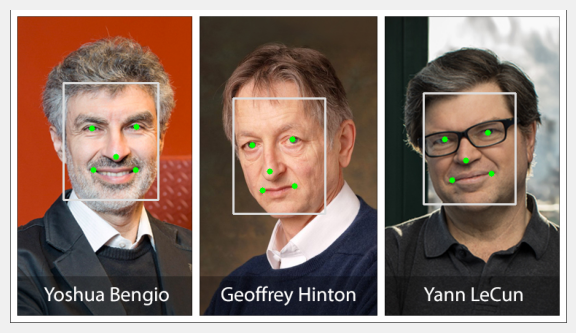

In [ ]:
det_threshold = [0.5, 0.6, 0.8]

detector = MTCNN()

one = cv2.imread('bengio-hinton-lecun.jpg')
faces = detector.detect_faces(one)  # FACES DETECTION

for face in faces:
    cv2.rectangle(one, tuple(face['box'][:2]), tuple([face['box'][0]+face['box'][2],face['box'][1]+face['box'][3]]), (220, 220, 220), 2)
    cv2.circle(one, face['keypoints']['left_eye'], 4, (0, 255, 0), -1)
    cv2.circle(one, face['keypoints']['right_eye'], 4, (0, 255, 0), -1)
    cv2.circle(one, face['keypoints']['nose'], 4, (0, 255, 0), -1)
    cv2.circle(one, face['keypoints']['mouth_left'], 4, (0, 255, 0), -1)
    cv2.circle(one, face['keypoints']['mouth_right'], 4, (0, 255, 0), -1)

plt.imshow(cv2.cvtColor(one,cv2.COLOR_BGR2RGB))
plt.rcParams['figure.figsize'] = [20, 10]
plt.axis('off')
plt.show()


🤔 **Who are they?**
[Check this out:](https://awards.acm.org/about/2018-turing)

## ✍🏼 Voluntary exercise: A Gentle Introduction to YOLOv8

Get hands-on experience with [YOLOv8](https://wandb.ai/mukilan/wildlife-yolov8/reports/A-Gentle-Introduction-to-YOLOv8--Vmlldzo0MDU5NDA2?galleryTag=object-detection) and write down the top three things that interested you the most.

1. ...
2. ...
3. ...



# Summary


<img src="https://su2.utia.cas.cz/files/labs/23-202/203_recap2.png">
